# Exploratory Data Analysis

## Introduction


Sleep:

- A single sleep period must be at least 30 minutes in length
- A single sleep period can be interrupted by bouts of activity that do not exceed 30 consecutive minutes
- No sleep windows can be detected unless the watch is deemed to be worn for the duration (elaborated upon, below)
- The longest sleep window during the night is the only one which is recorded
- If no valid sleep window is identifiable, neither an onset nor a wakeup event is recorded for that night.
- Sleep events do not need to straddle the day-line, and therefore there is no hard rule defining how many may occur within a given period. However, no more than one window should be assigned per night. For example, it is valid for an individual to have a sleep window from 01h00–06h00 and 19h00–23h30 in the same calendar day, though assigned to consecutive nights
- There are roughly as many nights recorded for a series as there are 24-hour periods in that series.


TODO:

- Try to find periods where the watch is not worn.

[To check](https://www.kaggle.com/code/shoabahamed/complete-incomplete-series-analysis#INCOMPLETE-AND-COMPLETE-SERIES)

## Import


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl

from pathlib import Path

In [2]:
df_signals = pl.read_parquet("data/train_series.parquet")

In [3]:
df_events = pd.read_csv("data/train_events.csv")

**Convert timestamp to datetime**


In [4]:
df_signals = df_signals.with_columns(
    pl.col("timestamp").str.to_datetime("%Y-%m-%dT%H:%M:%S%z")
)

In [5]:
df_events.timestamp = pd.to_datetime(df_events.timestamp)

**Min-max normalization**


In [6]:
# min-max scaling
cols_to_scale = ["anglez", "enmo"]
new_cols = [f"{col}_scaled" for col in cols_to_scale]

float_cols = df_signals.select(cols_to_scale).with_columns(
    (pl.col(cols_to_scale) - pl.col(cols_to_scale).min()) / (pl.col(cols_to_scale).max() - pl.col(cols_to_scale).min())
)

## Exploratory Data Analysis


**Missing Events**


In [7]:
df_events.isna().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
dtype: int64

**Missing Data**


In [8]:
(
    df_signals["timestamp"].is_null().sum()
    + df_signals["series_id"].is_null().sum()
    + df_signals["anglez"].is_null().sum()
    + df_signals["enmo"].is_null().sum()
)

0

**Same number of wake up and onset events for each series?**

In [9]:
missing_event_by_series = df_events.groupby("series_id")['timestamp'].apply(lambda x: x.isna().sum())
print(f"The total of missing events is {missing_event_by_series.sum()}")
missing_event_by_series[missing_event_by_series % 2 != 0]

The total of missing events is 4923


series_id
0ce74d6d2106     7
154fe824ed87     3
44a41bba1ee7    15
efbfc4526d58    39
f8a8da8bdd00     3
Name: timestamp, dtype: int64

**Same number of wake up and onset events for each night?**

In [10]:
missing_event_by_night = df_events.groupby("night")['timestamp'].apply(lambda x: x.isna().sum())
missing_event_by_night[missing_event_by_night % 2 != 0]

night
7     127
10    137
17    179
20    171
30     81
Name: timestamp, dtype: int64

**Is data balanced ?**

In [11]:
df_events.groupby("event").size()


event
onset     7254
wakeup    7254
dtype: int64

### Basic stats


**number of series**


In [12]:
len(df_signals["series_id"].unique())

277

**number of nights**


In [13]:
len(df_events["night"].unique())

84

**number of events**


In [14]:
len(df_events["event"])

14508

**number of event by night**


Text(0, 0.5, 'Number of events')

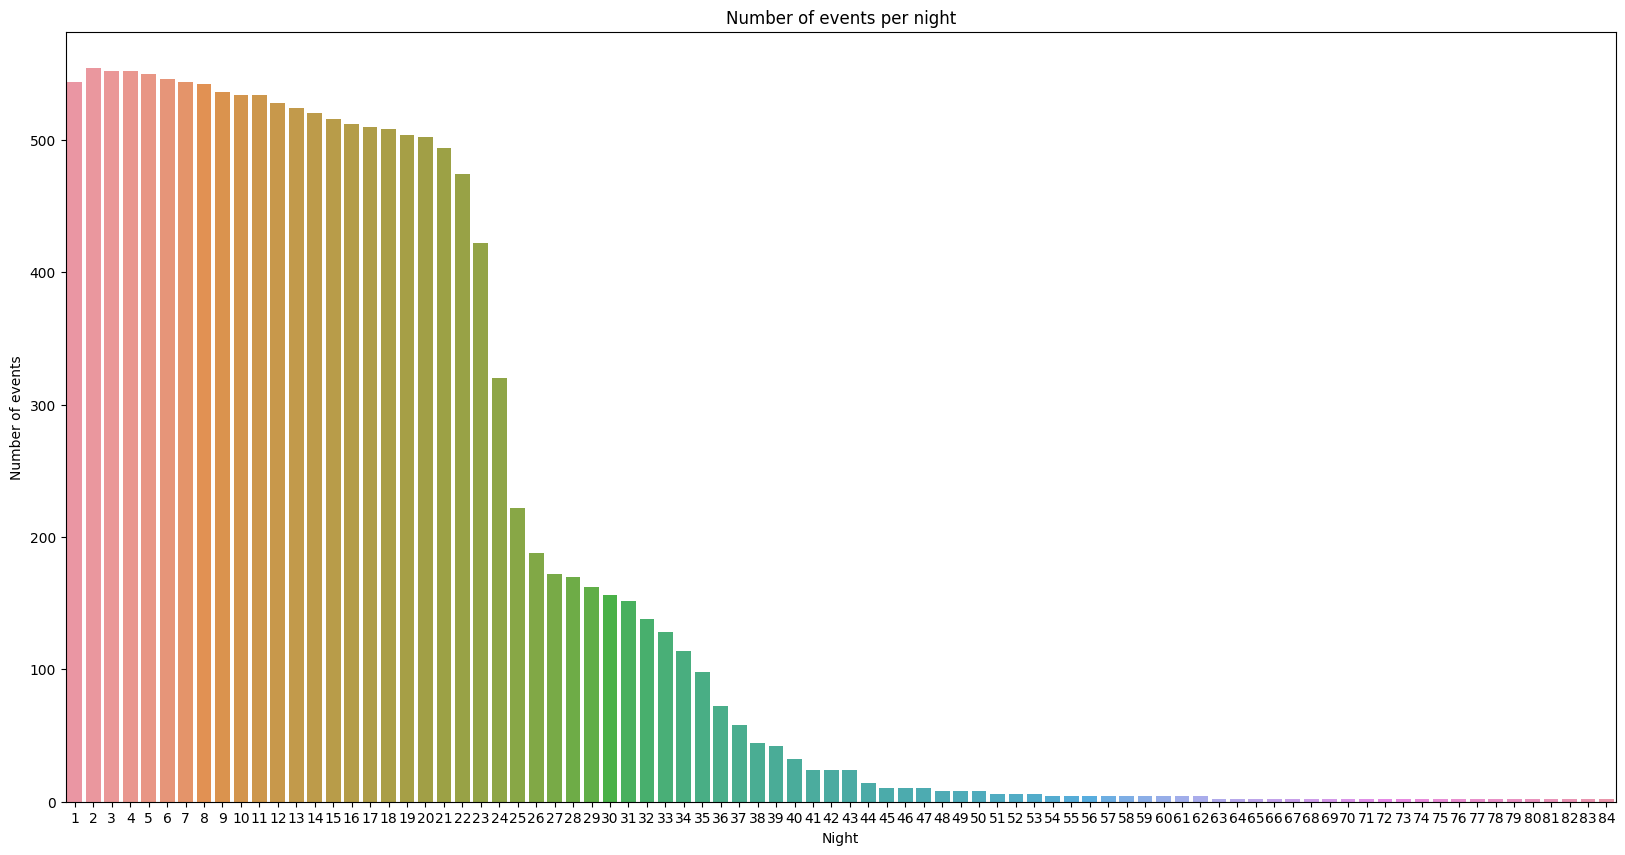

In [15]:
night_counts = df_events.groupby("night").size()
_, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=night_counts.reset_index(), x="night", y=0, ax=ax)
ax.set_title("Number of events per night")
ax.set_xlabel("Night")
ax.set_ylabel("Number of events")

**number of event by series**


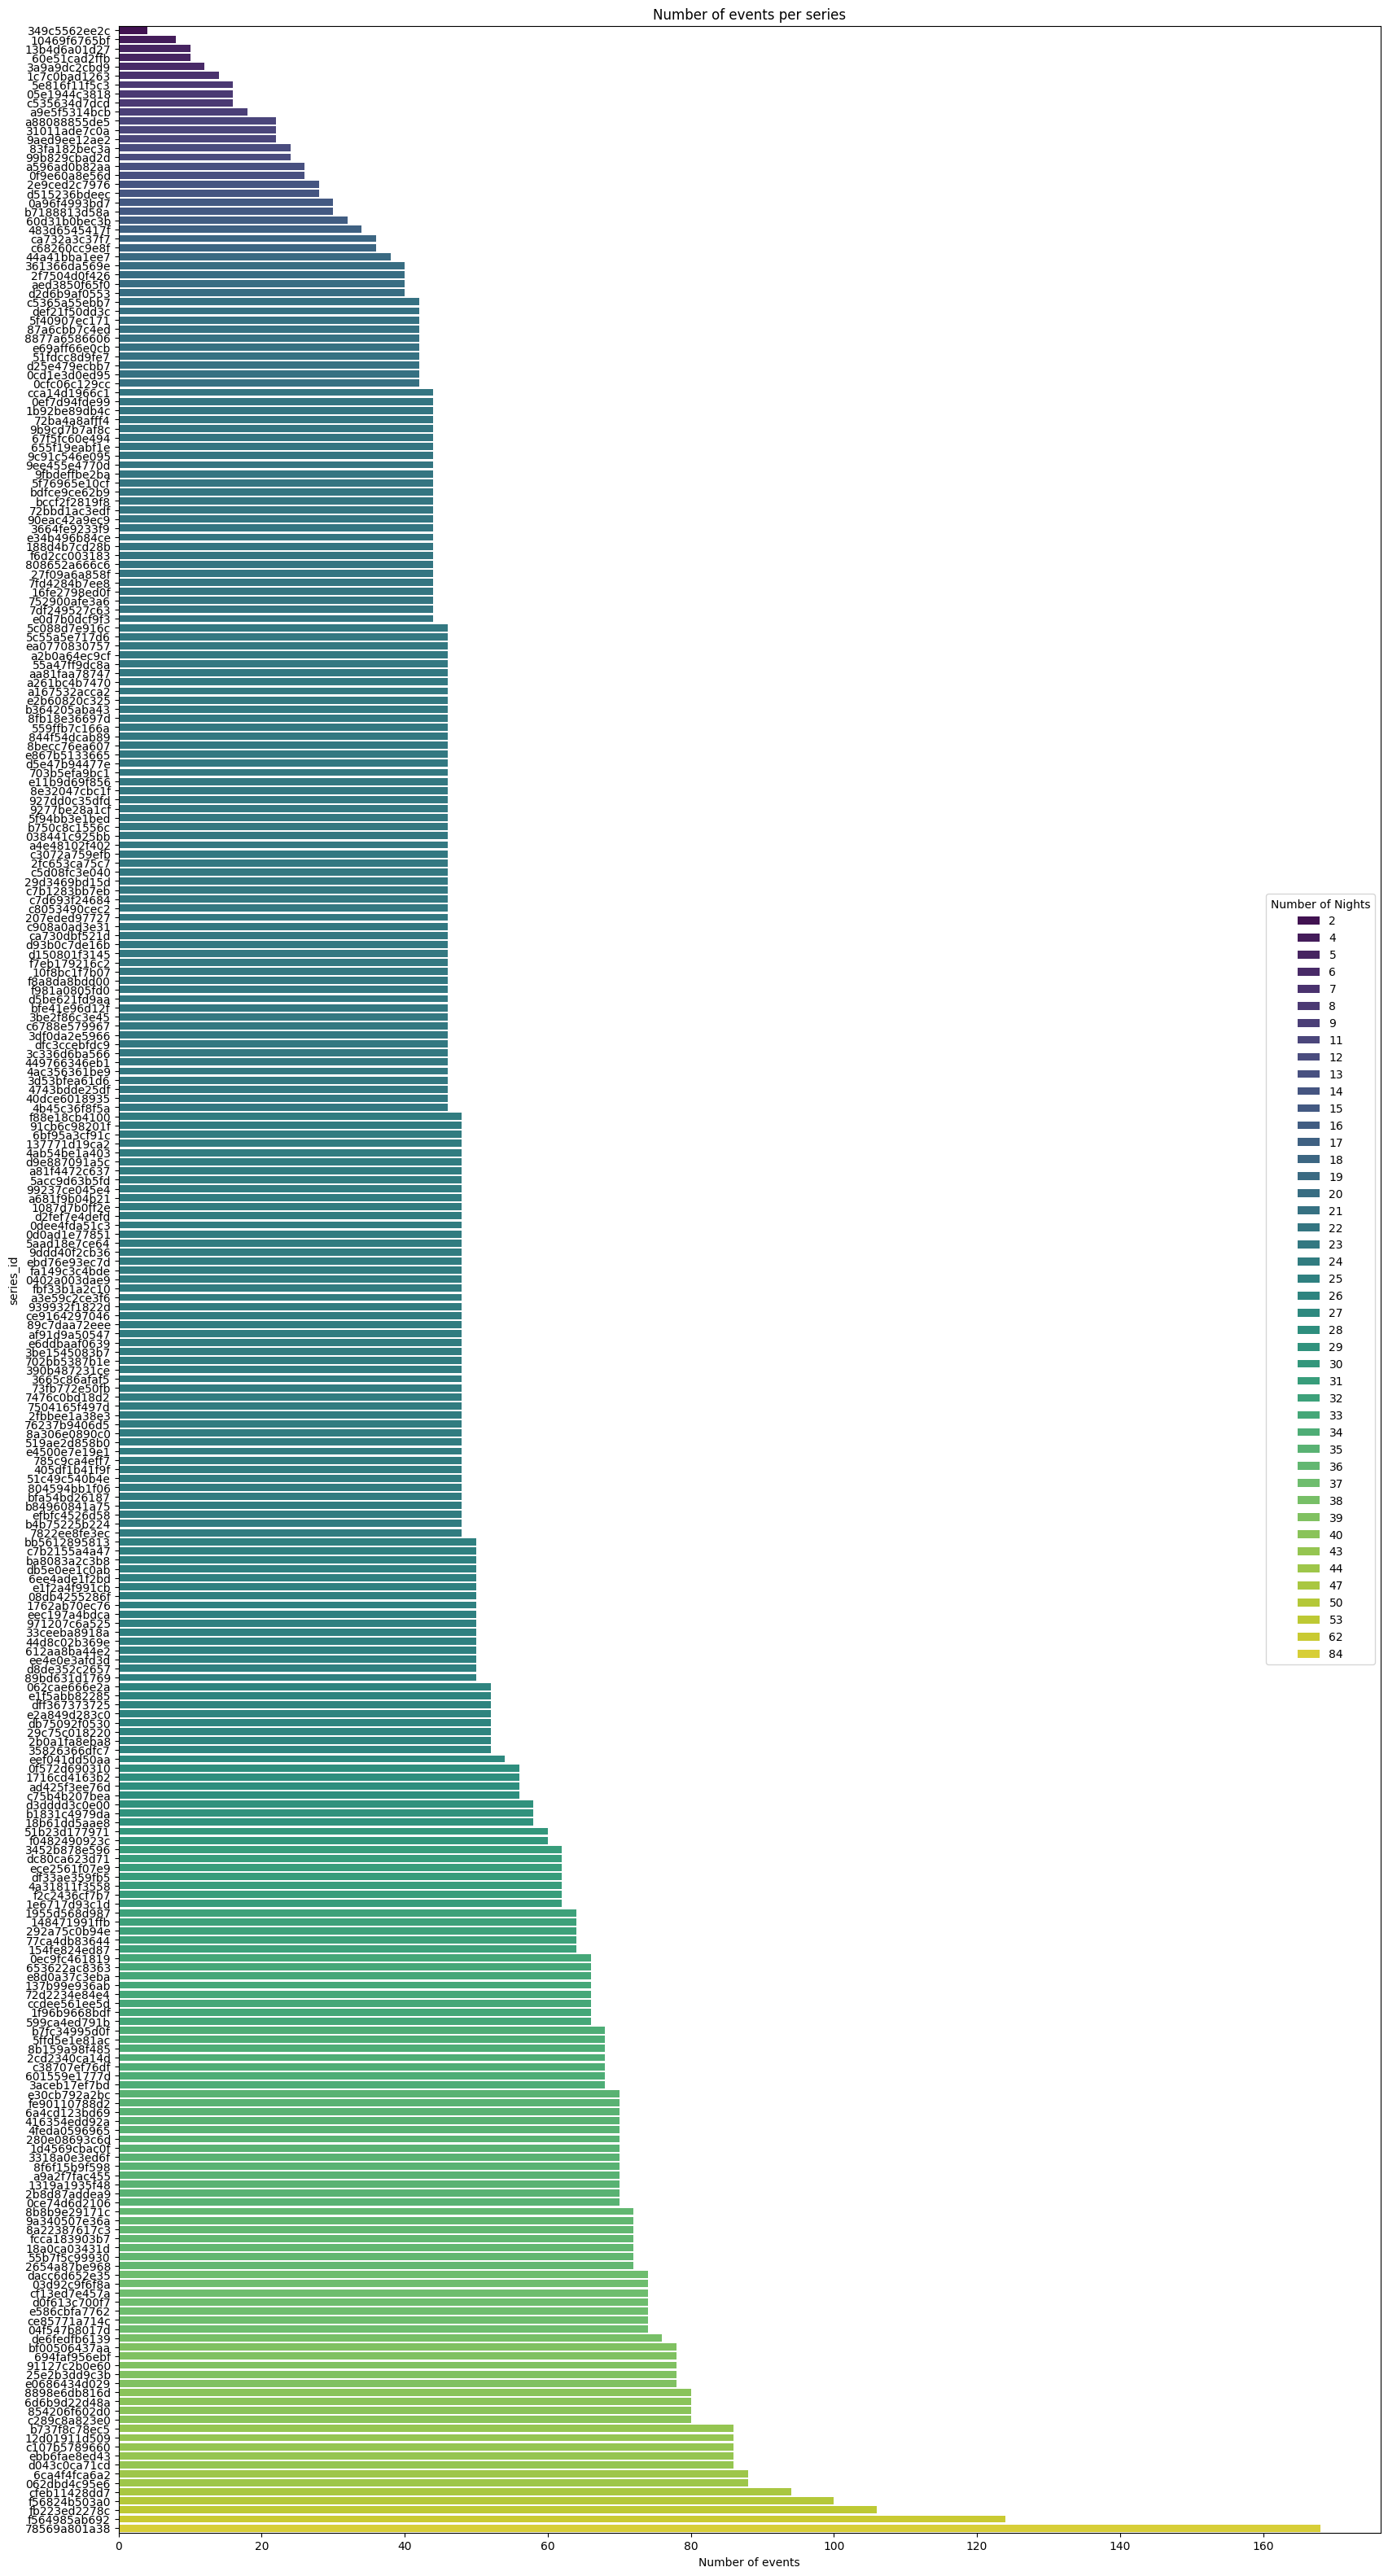

In [16]:
# Calculate number of nights by series and merge with event counts
df = (
    df_events.groupby("series_id")
    .agg(events=("series_id", "size"), nights=("night", "nunique"))
    .reset_index()
)

# Plot
plt.figure(figsize=(20, 40))
sns.barplot(
    data=df.sort_values(by="events", ascending=True),
    y="series_id",
    x="events",
    hue="nights",
    dodge=False,
    palette="viridis",
)

# Setting titles and labels
plt.title("Number of events per series")
plt.ylabel("series_id")
plt.xlabel("Number of events")
plt.legend(title="Number of Nights", loc="best")

plt.show()

**AngleZ**

A metric derived from individual accelerometer components that is commonly used in sleep detection, and refers to the angle of the arm relative to the vertical axis of the body.

In the range [-90,90]


In [17]:
df_signals["anglez"].describe()

statistic,value
str,f64
"""count""",1.2794634e8
"""null_count""",0.0
"""mean""",-8.810476
"""std""",35.521875
"""min""",-90.0
"""25%""",-31.8589
"""50%""",-9.5979
"""75%""",11.3002
"""max""",90.0


**enmo**

ENMO is the Euclidean Norm Minus One of all accelerometer signals, with negative values rounded to zero. While no standard measure of acceleration exists in this space, this is one of the several commonly computed features.

Positive values


In [18]:
df_signals["enmo"].describe()

statistic,value
str,f64
"""count""",1.2794634e8
"""null_count""",0.0
"""mean""",0.041315
"""std""",0.101829
"""min""",0.0
"""25%""",0.0013
"""50%""",0.0172
"""75%""",0.0437
"""max""",11.4337


### Times Series Visualization


In [19]:
def plot_signals(serie_id):
    df = df_signals.filter(df_signals["series_id"] == serie_id)
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    # AngleZ plot
    sns.lineplot(data=df[::1000], x="timestamp", y="anglez", ax=ax[0])
    ax[0].set_title("AngleZ over Time")
    ax[0].set_xlabel("Time")
    ax[0].set_ylabel("AngleZ")

    # ENMO plot
    sns.lineplot(data=df[::1000], x="timestamp", y="enmo", ax=ax[1])
    ax[1].set_title("ENMO over Time")
    ax[1].set_xlabel("Time")
    ax[1].set_ylabel("ENMO")
    fig.suptitle(f"Signals of patient : {serie_id}")
    plt.show()


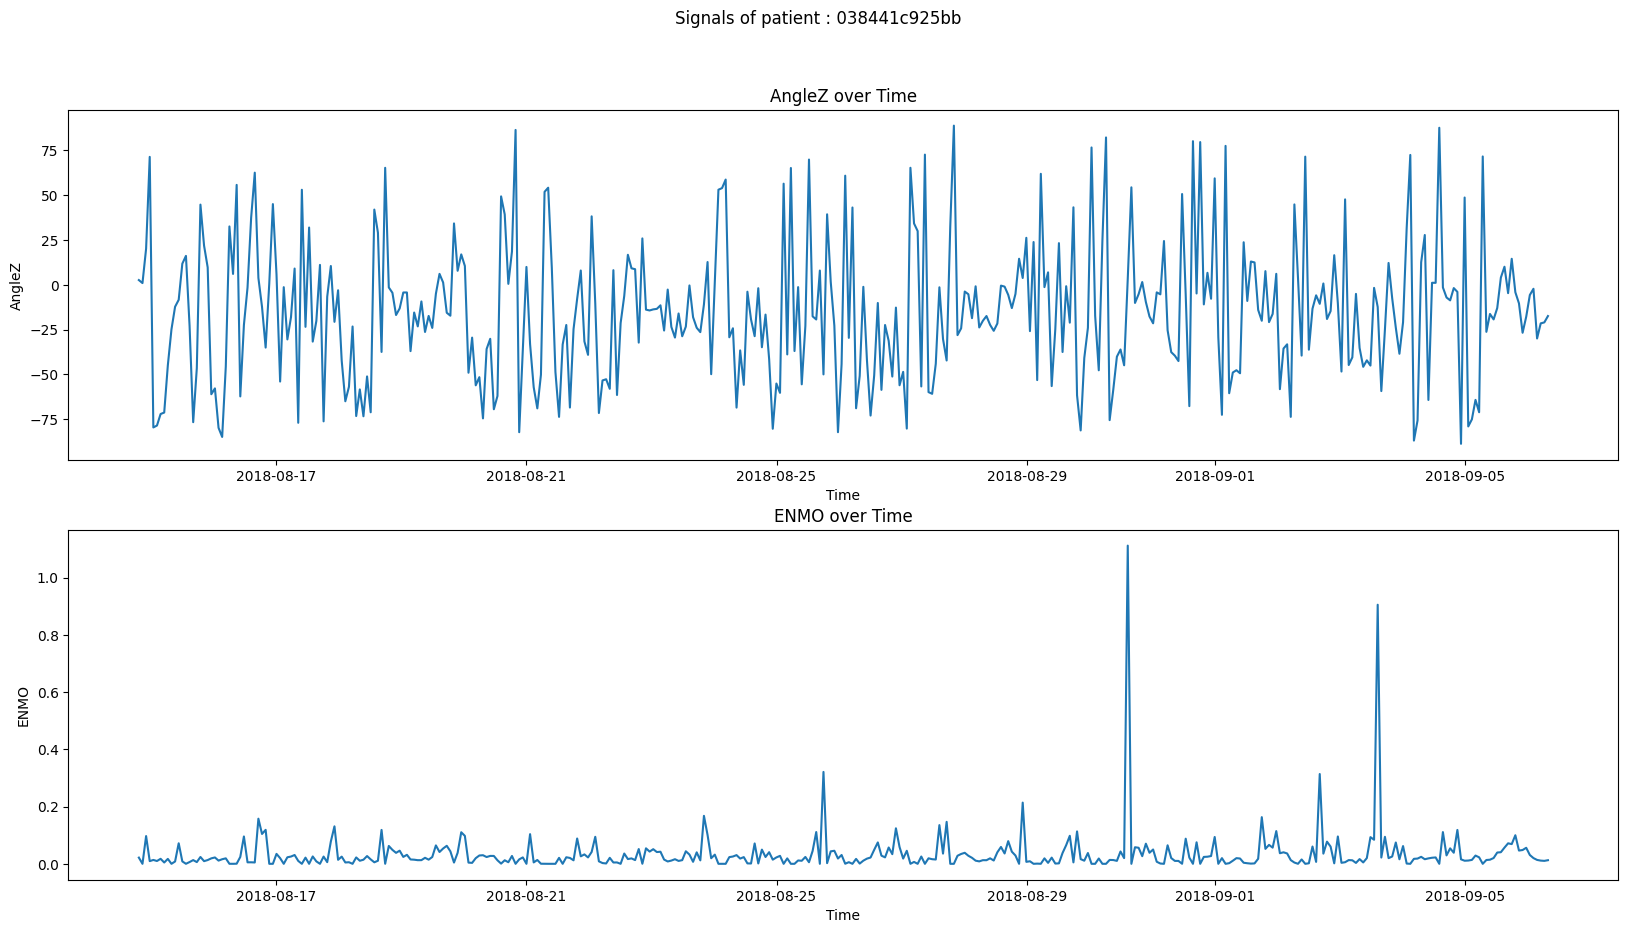

In [20]:
plot_signals("038441c925bb")

In [21]:
def plot_signals_distribution(serie_id):
    df = df_signals.filter(df_signals["series_id"] == serie_id)
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))

    # AngleZ plot
    sns.histplot(data=df, x="anglez", ax=ax[0], kde=True)
    ax[0].set_title("AngleZ distribution")
    ax[0].set_xlabel("AngleZ")
    ax[0].set_ylabel("Count")

    # ENMO plot
    sns.histplot(data=df, x="enmo", ax=ax[1], kde=False)
    ax[1].set_title("ENMO distribution")
    ax[1].set_xlabel("ENMO")
    ax[1].set_ylabel("Count")
    ax[1].set_yscale("log")
    ax[1].set_xscale("log")
    fig.suptitle(f"Distribution of signals for patient : {serie_id}")
    plt.show()

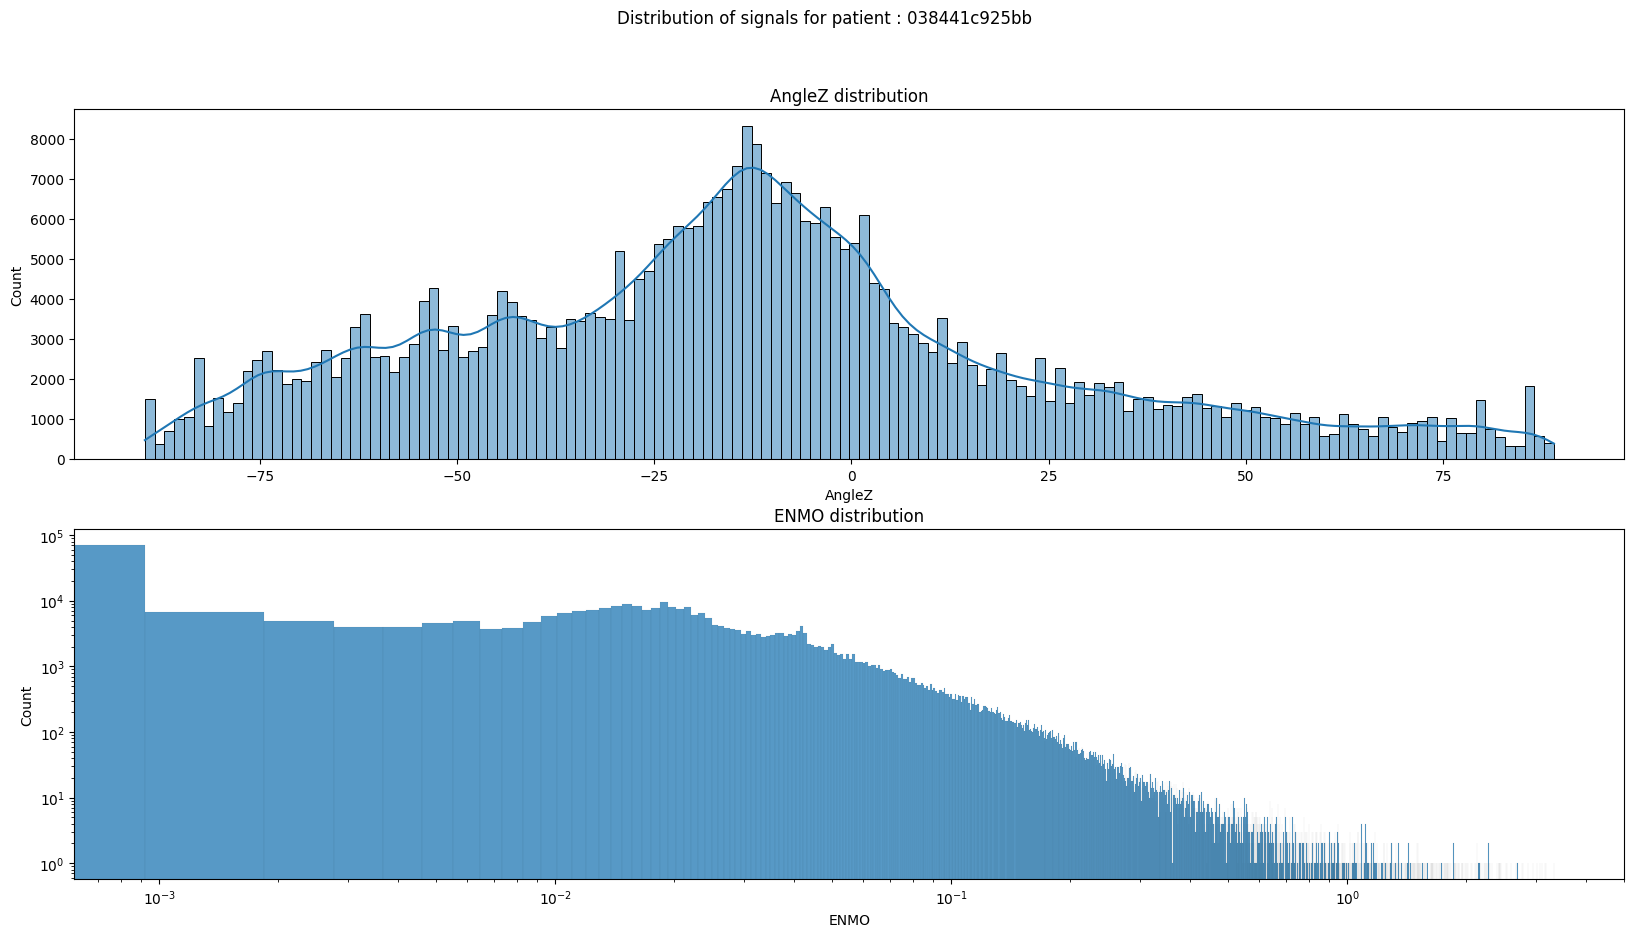

In [22]:
plot_signals_distribution("038441c925bb")

### Duration of each Series


In [23]:
duration = (
    df_signals.group_by("series_id")
    .agg(
        duration=pl.col("timestamp").max() - pl.col("timestamp").min(),
        nb_rows=pl.col("timestamp").count(),
    )
    .with_columns(pl.col("duration").cast(pl.Duration(time_unit="ms")))
)
duration

series_id,duration,nb_rows
str,duration[ms],u32
"""c908a0ad3e31""",23d 6h 59m 55s,402480
"""3df0da2e5966""",22d 10h 59m 55s,388080
"""0402a003dae9""",22d 23h 44m 55s,397260
"""0ef7d94fde99""",20d 23h 59m 55s,362880
"""612aa8ba44e2""",24d 20h 59m 55s,429840
"""c289c8a823e0""",40d 7h 44m 55s,696780
"""33ceeba8918a""",24d 5h 44m 55s,418860
"""ca732a3c37f7""",18d 11h 14m 55s,319140
"""31011ade7c0a""",32d 16h 29m 55s,564840


Text(0, 0.5, 'Percentage of Series')

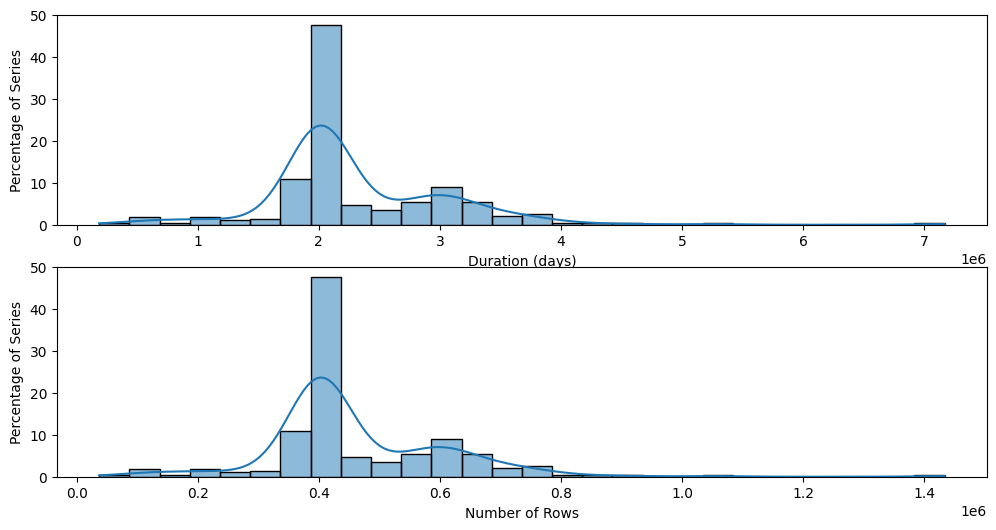

In [24]:
# Plot duration distribution
seconds = duration["duration"].dt.seconds()
nb_rows = duration["nb_rows"]
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

sns.histplot(data=seconds, kde=True, ax=ax1, stat="percent")
ax1.set_xlabel("Duration (days)")
ax1.set_ylabel("Percentage of Series")

sns.histplot(data=nb_rows, kde=True, ax=ax2, stat="percent")
ax2.set_xlabel("Number of Rows")
ax2.set_ylabel("Percentage of Series")

### Plot of the sleep of one series trough time


In [25]:
serie_signals = df_signals.filter(df_signals["series_id"] == "1b92be89db4c")
serie_events = df_events.query(f"series_id == '1b92be89db4c'")

In [26]:
def plot_sleep(
    serie_id: str, df_events: pd.DataFrame, ax: plt.Axes
) -> plt.Axes:
    """
    Plot sleep for a given serie_id

    Parameters
    ----------
    serie : str
        the serie_id to plot
    df_events : pd.DataFrame
        DataFrame containing the columns 'series_id', 'night', 'event', 'timestamp'
    """
    # Filter events for the given serie_id and sort by timestamp
    serie_events = df_events[df_events["series_id"] == serie_id].sort_values(
        by="timestamp", ascending=True
    )

    # Initialize containers for onsets and wakeups
    onset_times = []
    wakeup_times = []

    # Process events in order, pairing onsets with subsequent wakeups
    for idx, row in serie_events.iterrows():
        if row["event"] == "onset":
            onset_times.append(row["timestamp"])
        elif row["event"] == "wakeup" and onset_times:
            # Only plot if there is a previous 'onset' to pair with
            onset = onset_times.pop()
            wakeup = row["timestamp"]

            ax.plot(
                [onset, wakeup],
                [0.5, 0.5],
                color="blue",
                lw=10,
                solid_capstyle="butt",
            )

    ax.set_yticks([])
    ax.set_xlabel("Time")
    ax.set_title(f"Sleep Periods for {serie_id}")

    return ax

In [27]:
def plot_signals(
    serie: str, df_signals: pl.DataFrame, ax: plt.Axes
) -> plt.Axes:
    """
    Plot signals for a given serie_id

    Parameters
    ----------
    serie : str
        the serie_id to plot
    df_signals : pl.DataFrame
        DataFrame containing the columns 'series_id', 'timestamp', 'anglez', 'enmo'
    """
    # Filter signals for the given serie_id and sort by timestamp
    serie_signals = df_signals.filter(df_signals["series_id"] == serie).sort(
        "timestamp"
    )
    sns.lineplot(
        data=serie_signals[::100], x="timestamp", y="anglez", alpha=0.5
    )
    sns.lineplot(data=serie_signals[::100], x="timestamp", y="enmo", alpha=0.5)
    ax.set_title(f"Signals for {serie}")

    return ax

<Axes: title={'center': 'Signals for 1b92be89db4c'}, xlabel='Time', ylabel='anglez'>

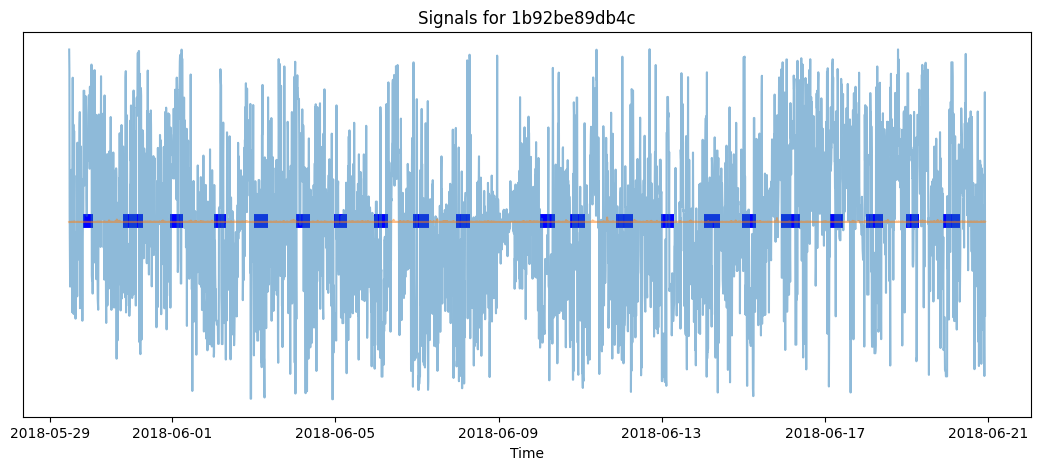

In [28]:
_, ax = plt.subplots(figsize=(13, 5))
plot_sleep("1b92be89db4c", df_events, ax)
plot_signals("1b92be89db4c", df_signals, ax)

In [29]:
import plotly
import plotly.graph_objs as go


def plot_sleep_interactive(
    serie_id: str, df_events: pd.DataFrame, df_signals: pl.DataFrame
):
    """
    Plot sleep for a given serie_id

    Parameters
    ----------
    serie : str
        the serie_id to plot
    df_events : pd.DataFrame
        DataFrame containing the columns 'series_id', 'night', 'event', 'timestamp'
    df_signals : pl.DataFrame
        DataFrame containing the columns 'series_id', 'timestamp', 'anglez', 'enmo'
    """
    # Filter events for the given serie_id and sort by timestamp
    serie_events = df_events[df_events["series_id"] == serie_id].sort_values(
        by="timestamp", ascending=True
    )
    serie_signals = df_signals.filter(df_signals["series_id"] == serie_id).sort(
        "timestamp"
    )

    # _________________________________________________________________
    # Initialize layout
    # _________________________________________________________________

    traces = []
    layout = go.Layout(
        title=f"Sleep Periods for {serie_id}",
        xaxis=dict(
            title="Time",
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=True,
        ),
        yaxis=dict(
            title="",
            showgrid=False,
            zeroline=False,
            showline=False,
            showticklabels=False,
        ),
        showlegend=False,
        width=1280,
        height=720,
    )

    # _________________________________________________________________
    # Plot signals
    # _________________________________________________________________

    trace_anglez = go.Scatter(
        x=serie_signals["timestamp"],
        y=serie_signals["anglez"],
        mode="lines",
        line=dict(
            color="green",
            width=1,
        ),
        hoverinfo="none",
    )
    traces.append(trace_anglez)

    trace_enmo = go.Scatter(
        x=serie_signals["timestamp"],
        y=serie_signals["enmo"],
        mode="lines",
        line=dict(
            color="red",
            width=1,
        ),
        hoverinfo="none",
    )
    traces.append(trace_enmo)

    # _________________________________________________________________
    # Plot sleep periods
    # _________________________________________________________________

    # Initialize containers for onsets and wakeups
    onset_times = []
    wakeup_times = []

    # Process events in order, pairing onsets with subsequent wakeups
    for idx, row in serie_events.iterrows():
        if row["event"] == "onset":
            onset_times.append(row["timestamp"])
        elif row["event"] == "wakeup" and onset_times:
            # Only plot if there is a previous 'onset' to pair with
            onset = onset_times.pop()
            wakeup = row["timestamp"]

            trace = go.Scatter(
                x=[onset, wakeup],
                y=[0.5,0.5],
                mode="lines",
                line=dict(
                    color="blue",
                    width=10,
                ),
                hoverinfo="none",
            )
            traces.append(trace)

    fig = go.Figure(data=traces, layout=layout)
    #plotly.offline.iplot(fig)
    return fig

**Save all the plots**

In [30]:
EXPORT_ALL_PLOTS = False

if EXPORT_ALL_PLOTS:
    for serie_id in df_signals["series_id"].unique():
        if not Path(f"plots/{serie_id}.html").exists():
            plot_sleep_interactive(serie_id, df_events, df_signals).write_html(f"plots/{serie_id}.html")
else:
    print("Skipping export of all plots")

Skipping export of all plots
